<h1><center>Big Data Analytics for Short Term Load Forecasting using Hybrid Artificial Neural Network</center></h1>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from datetime import date
import holidays
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('bmh') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L1
from sklearn.metrics import r2_score, explained_variance_score

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# pip install holidays

warnings.filterwarnings("ignore")

E:\Softwares\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Data Preprocessing

### Dataset contains the load data from January 2017 to October 2022

## Load Data Preprocessing

In [2]:
load_data = pd.read_excel("2017-2022.xlsx", sheet_name="Sheet1")
load_data

,datetime,demand load,sldc load,scada load,od/ud sldc load,od/ud scada load
0,01-01-2017 00:00:00,635.0,710.0,756.0,75.0,121.0
1,01-01-2017 00:15:00,730.0,682.0,730.0,-48.0,0.0
2,01-01-2017 00:30:00,686.0,660.0,701.0,-26.0,15.0
3,01-01-2017 00:45:00,645.0,641.0,674.0,-4.0,29.0
4,01-01-2017 01:00:00,628.0,620.0,650.0,-8.0,22.0
...,...,...,...,...,...,...
204475,31-10-2022 22:45:00,1053.0,1032.0,1032.0,-21.0,-21.0
204476,31-10-2022 23:00:00,1039.0,1008.0,1007.0,-31.0,-32.0
204477,31-10-2022 23:15:00,1013.0,984.0,982.0,-29.0,-31.0
204478,31-10-2022 23:30:00,963.0,957.0,957.0,-6.0,-6.0


In [3]:
load_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204480 entries, 0 to 204479
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   datetime          204480 non-null  object 
 1   demand load       202738 non-null  float64
 2   sldc load         202738 non-null  float64
 3   scada load        202738 non-null  float64
 4   od/ud sldc load   204480 non-null  float64
 5   od/ud scada load  204480 non-null  float64
dtypes: float64(5), object(1)
memory usage: 9.4+ MB


In [4]:
load_data.describe()

,demand load,sldc load,scada load,od/ud sldc load,od/ud scada load
count,202738.000000,202738.000000,202738.000000,204480.000000,204480.000000
mean,1543.773984,1534.804437,1517.551100,-8.893134,-25.999487
std,527.918990,525.863416,531.549262,55.338041,79.380589
min,399.000000,400.000000,449.000000,-298.000000,-299.000000
25%,1170.000000,1163.000000,1127.000000,-38.000000,-55.000000
50%,1496.000000,1483.000000,1473.000000,-7.500000,-13.000000
75%,1924.000000,1912.000000,1890.000000,21.000000,17.000000
max,3455.000000,3345.000000,3405.000000,299.000000,299.000000


In [5]:
load_data.isnull().sum()

datetime               0
demand load         1742
sldc load           1742
scada load          1742
od/ud sldc load        0
od/ud scada load       0
dtype: int64

### To handling the missing value, spline Interpolation is used to estimating unknown data points in a given range.

### Interpolation of DEMAND, SLDC and SCADA load data

In [6]:
load_data['DEMAND LOAD'] = load_data['demand load'].interpolate(option='spline', 
                                                                order=5, 
                                                                limit_direction='both')

load_data['SLDC LOAD'] = load_data['sldc load'].interpolate(option='spline', 
                                                            order=5, 
                                                            limit_direction='both')

load_data['SCADA LOAD'] = load_data['scada load'].interpolate(option='spline', 
                                                              order=5, 
                                                              limit_direction='both')

### Description of dataset after interpolation of missing data

In [7]:
load_data = pd.DataFrame([load_data['datetime'], 
                          load_data['DEMAND LOAD'], 
                          load_data['SLDC LOAD'], 
                          load_data['SCADA LOAD']]).transpose()
load_data

,datetime,DEMAND LOAD,SLDC LOAD,SCADA LOAD
0,01-01-2017 00:00:00,635.0,710.0,756.0
1,01-01-2017 00:15:00,730.0,682.0,730.0
2,01-01-2017 00:30:00,686.0,660.0,701.0
3,01-01-2017 00:45:00,645.0,641.0,674.0
4,01-01-2017 01:00:00,628.0,620.0,650.0
...,...,...,...,...
204475,31-10-2022 22:45:00,1053.0,1032.0,1032.0
204476,31-10-2022 23:00:00,1039.0,1008.0,1007.0
204477,31-10-2022 23:15:00,1013.0,984.0,982.0
204478,31-10-2022 23:30:00,963.0,957.0,957.0


In [8]:
load_data.isnull().sum()

datetime       0
DEMAND LOAD    0
SLDC LOAD      0
SCADA LOAD     0
dtype: int64

### Load Dataset 

In [9]:
final_load_dataset = pd.DataFrame([load_data['DEMAND LOAD'], 
                                   load_data['SLDC LOAD'], 
                                   load_data['SCADA LOAD']]).transpose()

final_load_dataset.index = pd.to_datetime(load_data['datetime'].astype(str))
final_load_dataset = final_load_dataset.rename_axis('datetime').reset_index()
final_load_dataset

,datetime,DEMAND LOAD,SLDC LOAD,SCADA LOAD
0,2017-01-01 00:00:00,635.0,710.0,756.0
1,2017-01-01 00:15:00,730.0,682.0,730.0
2,2017-01-01 00:30:00,686.0,660.0,701.0
3,2017-01-01 00:45:00,645.0,641.0,674.0
4,2017-01-01 01:00:00,628.0,620.0,650.0
...,...,...,...,...
204475,2022-10-31 22:45:00,1053.0,1032.0,1032.0
204476,2022-10-31 23:00:00,1039.0,1008.0,1007.0
204477,2022-10-31 23:15:00,1013.0,984.0,982.0
204478,2022-10-31 23:30:00,963.0,957.0,957.0


In [10]:
final_load_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204480 entries, 0 to 204479
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     204480 non-null  datetime64[ns]
 1   DEMAND LOAD  204480 non-null  float64       
 2   SLDC LOAD    204480 non-null  float64       
 3   SCADA LOAD   204480 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 6.2 MB


In [11]:
final_load_dataset.describe()

,DEMAND LOAD,SLDC LOAD,SCADA LOAD
count,204480.000000,204480.000000,204480.000000
mean,1543.867527,1534.892163,1517.803775
std,527.497234,525.373783,531.071648
min,399.000000,400.000000,449.000000
25%,1170.000000,1163.000000,1127.000000
50%,1497.000000,1485.000000,1475.000000
75%,1924.000000,1912.000000,1890.000000
max,3455.000000,3345.000000,3405.000000


## Weather Data Preprocessing

In [12]:
weather_data = pd.read_csv("2017-01-01 to 2022-10-31.csv")
weather_data.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"G7R6 P5G, Balaji Estate, Kalkaji, New Delhi, D...",2017-01-01T00:00:00,13.0,13.0,12.0,93.65,0.0,0,NaN,0.0,...,NaN,0.0,1.0,0.0,NaN,0.0,NaN,Clear,clear-night,"VIDP,42181099999"
1,"G7R6 P5G, Balaji Estate, Kalkaji, New Delhi, D...",2017-01-01T01:00:00,13.0,13.0,12.0,93.65,0.0,0,NaN,0.0,...,NaN,0.0,1.0,0.0,NaN,0.0,NaN,Clear,clear-night,"VIDP,42181099999"
2,"G7R6 P5G, Balaji Estate, Kalkaji, New Delhi, D...",2017-01-01T02:00:00,12.2,12.2,11.7,97.01,0.0,0,NaN,0.0,...,1016.1,0.0,1.0,0.0,NaN,0.0,NaN,Clear,clear-night,"42182099999,VIDP,42181099999"
3,"G7R6 P5G, Balaji Estate, Kalkaji, New Delhi, D...",2017-01-01T03:00:00,12.0,12.0,11.0,93.60,0.0,0,NaN,0.0,...,NaN,0.0,1.0,0.0,NaN,0.0,NaN,Clear,clear-night,"VIDP,42181099999"
4,"G7R6 P5G, Balaji Estate, Kalkaji, New Delhi, D...",2017-01-01T04:00:00,12.0,12.0,11.0,93.60,0.0,0,NaN,0.0,...,NaN,0.0,0.0,0.0,NaN,0.0,NaN,Clear,clear-night,"VIDP,42181099999"


In [13]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51121 entries, 0 to 51120
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              51121 non-null  object 
 1   datetime          51121 non-null  object 
 2   temp              51121 non-null  float64
 3   feelslike         51121 non-null  float64
 4   dew               51121 non-null  float64
 5   humidity          51121 non-null  float64
 6   precip            51121 non-null  float64
 7   precipprob        51121 non-null  int64  
 8   preciptype        1257 non-null   object 
 9   snow              50534 non-null  float64
 10  snowdepth         50534 non-null  float64
 11  windgust          9068 non-null   float64
 12  windspeed         51121 non-null  float64
 13  winddir           51121 non-null  float64
 14  sealevelpressure  26680 non-null  float64
 15  cloudcover        51121 non-null  float64
 16  visibility        50524 non-null  float6

In [14]:
weather_data.describe()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,51121.000000,51121.000000,51121.000000,51121.000000,51121.000000,51121.000000,50534.0,50534.0,9068.000000,51121.000000,51121.000000,26680.000000,51121.000000,50524.000000,51095.000000,27787.000000,51095.000000,7063.000000
mean,25.533190,27.466933,16.607885,63.499998,0.105216,1.885722,0.0,0.0,20.493913,7.613284,163.750204,1007.670165,33.798038,2.739015,224.453626,1.485284,2.235052,10.371797
std,8.290339,10.285564,6.988801,23.399803,1.615397,13.602201,0.0,0.0,11.920981,5.812156,118.928169,7.086380,31.939148,1.469905,301.215982,1.075950,3.028023,4.547519
min,0.800000,-1.500000,-11.700000,5.030000,0.000000,0.000000,0.0,0.0,0.700000,0.000000,0.000000,987.700000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,19.000000,19.000000,11.000000,45.270000,0.000000,0.000000,0.0,0.0,10.100000,2.800000,55.000000,1002.000000,0.000000,2.000000,0.000000,0.500000,0.000000,10.000000
50%,27.000000,27.800000,15.900000,65.490000,0.000000,0.000000,0.0,0.0,18.700000,7.600000,150.000000,1007.000000,29.000000,2.900000,10.500000,1.500000,0.000000,10.000000
75%,31.700000,35.600000,23.700000,83.650000,0.000000,0.000000,0.0,0.0,31.700000,11.200000,272.000000,1013.800000,54.700000,3.800000,450.000000,2.400000,5.000000,10.000000
max,47.500000,57.300000,30.000000,100.000000,91.645000,100.000000,0.0,0.0,85.300000,203.800000,360.000000,1025.600000,100.000000,24.100000,1047.000000,3.800000,10.000000,60.000000


### Eliminate the unwanted columns from the weather data and create a dataframe by using temperature and humidity data only.

In [15]:
hourly_weather_data = pd.DataFrame([weather_data['temp'], 
                                    weather_data['humidity']]).transpose()

hourly_weather_data.index = pd.to_datetime(weather_data['datetime'])
hourly_weather_data

,temp,humidity
datetime,,
2017-01-01 00:00:00,13.0,93.65
2017-01-01 01:00:00,13.0,93.65
2017-01-01 02:00:00,12.2,97.01
2017-01-01 03:00:00,12.0,93.60
2017-01-01 04:00:00,12.0,93.60
...,...,...
2022-10-31 20:00:00,22.3,81.54
2022-10-31 21:00:00,23.0,64.72
2022-10-31 22:00:00,22.0,73.29


### Checking for null values in temperature and humidity data

In [16]:
hourly_weather_data.isnull().sum()

temp        0
humidity    0
dtype: int64

In [17]:
hourly_weather_data.describe()

,temp,humidity
count,51121.000000,51121.000000
mean,25.533190,63.499998
std,8.290339,23.399803
min,0.800000,5.030000
25%,19.000000,45.270000
50%,27.000000,65.490000
75%,31.700000,83.650000
max,47.500000,100.000000


### Convert the hourly data into 15 minutes slots

In [18]:
temperature = pd.DataFrame(hourly_weather_data.temp.resample('15Min').mean()).interpolate(method= 'spline', 
                                                                                          order= 5, 
                                                                                          limit_direction= 'both')

humidity = pd.DataFrame(hourly_weather_data.humidity.resample('15Min').mean()).interpolate(method= 'spline', 
                                                                                           order= 5, 
                                                                                           limit_direction= 'both')

In [19]:
minutes_weather_data = pd.DataFrame([temperature['temp'], humidity['humidity']]).transpose()
minutes_weather_data.reset_index()
minutes_weather_data.head()

,temp,humidity
datetime,,
2017-01-01 00:00:00,13.000000,93.650000
2017-01-01 00:15:00,12.947809,93.897439
2017-01-01 00:30:00,13.016861,94.251461
2017-01-01 00:45:00,13.059741,94.523641
2017-01-01 01:00:00,13.000000,93.650000


In [20]:
minutes_weather_data.describe()

,temp,humidity
count,204481.000000,204481.000000
mean,25.533311,63.499588
std,8.240901,23.338832
min,0.800000,-6.087674
25%,19.260748,45.370000
50%,27.089904,65.490000
75%,31.558436,83.511697
max,47.500000,116.265025


### Weather Dataset

In [21]:
final_weather_dataset = pd.DataFrame([minutes_weather_data['temp'], 
                                      minutes_weather_data['humidity']]).transpose().iloc[:-1]

final_weather_dataset = final_weather_dataset.reset_index()
final_weather_dataset.head()

,datetime,temp,humidity
0,2017-01-01 00:00:00,13.000000,93.650000
1,2017-01-01 00:15:00,12.947809,93.897439
2,2017-01-01 00:30:00,13.016861,94.251461
3,2017-01-01 00:45:00,13.059741,94.523641
4,2017-01-01 01:00:00,13.000000,93.650000


In [22]:
final_weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204480 entries, 0 to 204479
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  204480 non-null  datetime64[ns]
 1   temp      204480 non-null  float64       
 2   humidity  204480 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.7 MB


In [23]:
final_weather_dataset.describe()

,temp,humidity
count,204480.000000,204480.000000
mean,25.533338,63.499495
std,8.240912,23.338851
min,0.800000,-6.087674
25%,19.260734,45.370000
50%,27.089993,65.490000
75%,31.558437,83.511709
max,47.500000,116.265025


In [24]:
final_weather_dataset.isnull().sum()

datetime    0
temp        0
humidity    0
dtype: int64

### Migration of Load and Weather dataset for feature engineering

In [25]:
final_dataset = pd.DataFrame([final_weather_dataset['temp'], 
                              final_weather_dataset['humidity'],
                              final_load_dataset['DEMAND LOAD'],
                              final_load_dataset['SLDC LOAD'],
                              final_load_dataset['SCADA LOAD']]).transpose()

final_dataset.index = pd.to_datetime(load_data['datetime'].astype(str), format='%d-%m-%Y %H:%M:%S')

final_dataset = final_dataset.rename_axis('DATETIME').reset_index()
final_dataset.columns = ['DATETIME', 'TEMPERATURE', 'HUMIDITY', 'DEMAND LOAD', 'SLDC LOAD', 'SCADA LOAD']
final_dataset = final_dataset[['DATETIME', 'TEMPERATURE', 'HUMIDITY', 'DEMAND LOAD', 'SLDC LOAD', 'SCADA LOAD']]

In [26]:
final_dataset.head()

,DATETIME,TEMPERATURE,HUMIDITY,DEMAND LOAD,SLDC LOAD,SCADA LOAD
0,2017-01-01 00:00:00,13.000000,93.650000,635.0,710.0,756.0
1,2017-01-01 00:15:00,12.947809,93.897439,730.0,682.0,730.0
2,2017-01-01 00:30:00,13.016861,94.251461,686.0,660.0,701.0
3,2017-01-01 00:45:00,13.059741,94.523641,645.0,641.0,674.0
4,2017-01-01 01:00:00,13.000000,93.650000,628.0,620.0,650.0


In [27]:
final_dataset.shape

(204480, 6)

In [28]:
final_dataset.size

1226880

In [29]:
final_dataset.isnull().sum()

DATETIME       0
TEMPERATURE    0
HUMIDITY       0
DEMAND LOAD    0
SLDC LOAD      0
SCADA LOAD     0
dtype: int64

In [30]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204480 entries, 0 to 204479
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   DATETIME     204480 non-null  datetime64[ns]
 1   TEMPERATURE  204480 non-null  float64       
 2   HUMIDITY     204480 non-null  float64       
 3   DEMAND LOAD  204480 non-null  float64       
 4   SLDC LOAD    204480 non-null  float64       
 5   SCADA LOAD   204480 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 9.4 MB


In [31]:
final_dataset.describe()

,TEMPERATURE,HUMIDITY,DEMAND LOAD,SLDC LOAD,SCADA LOAD
count,204480.000000,204480.000000,204480.000000,204480.000000,204480.000000
mean,25.533338,63.499495,1543.867527,1534.892163,1517.803775
std,8.240912,23.338851,527.497234,525.373783,531.071648
min,0.800000,-6.087674,399.000000,400.000000,449.000000
25%,19.260734,45.370000,1170.000000,1163.000000,1127.000000
50%,27.089993,65.490000,1497.000000,1485.000000,1475.000000
75%,31.558437,83.511709,1924.000000,1912.000000,1890.000000
max,47.500000,116.265025,3455.000000,3345.000000,3405.000000


# Feature Engineering 

In [32]:
dataset = pd.read_excel('PreprocessingData.xlsx')
dataset.head()

,DATETIME,TEMPERATURE,HUMIDITY,DEMAND LOAD,SLDC LOAD,SCADA LOAD
0,2017-01-01 00:00:00,13.000000,93.650000,635.0,710.0,756.0
1,2017-01-01 00:15:00,12.947809,93.897439,730.0,682.0,730.0
2,2017-01-01 00:30:00,13.016861,94.251461,686.0,660.0,701.0
3,2017-01-01 00:45:00,13.059741,94.523641,645.0,641.0,674.0
4,2017-01-01 01:00:00,13.000000,93.650000,628.0,620.0,650.0


### Identify Holidays to use as a feature for a model

In [33]:
holiday_list, list_of_years=([] for i in range(2))
year = pd.DatetimeIndex(dataset['DATETIME']).year

for i in year:
    if i not in list_of_years:
        list_of_years.append(i)

for holiday in holidays.India(years = list_of_years).items():
    holiday_list.append(holiday)
    
holidays_df = pd.DataFrame(holiday_list, columns=["DATE", "HOLIDAY"])
holidays_df

,DATE,HOLIDAY
0,2017-01-14,Makar Sankranti / Pongal
1,2017-01-26,Republic Day
2,2017-08-15,Independence Day
3,2017-10-02,Gandhi Jayanti
4,2017-05-01,Labour Day
5,2017-12-25,Christmas
6,2017-10-19,Diwali
7,2017-03-13,Holi
8,2018-01-14,Makar Sankranti / Pongal
9,2018-01-26,Republic Day


In [34]:
date_range = pd.to_datetime(dataset['DATETIME']).dt.date
is_holiday = []

for date in date_range:
    if date in  list(holidays_df['DATE']):
        is_holiday.append([date,1])
    else:
        is_holiday.append([date,0])

is_holiday = pd.DataFrame(is_holiday)
is_holiday.columns = ["DATE", "IS_HOLIDAY"]
is_holiday

,DATE,IS_HOLIDAY
0,2017-01-01,0
1,2017-01-01,0
2,2017-01-01,0
3,2017-01-01,0
4,2017-01-01,0
...,...,...
204475,2022-10-31,0
204476,2022-10-31,0
204477,2022-10-31,0
204478,2022-10-31,0


### Creating features like Day of year, Season, Week of year, Quarter from Datetime feature

In [35]:
dataset['YEAR'] = pd.DatetimeIndex(dataset['DATETIME']).year
dataset['MONTH'] = pd.DatetimeIndex(dataset['DATETIME']).month
dataset['DAY'] = pd.DatetimeIndex(dataset['DATETIME']).day
dataset['DAY_OF_YEAR'] = pd.DatetimeIndex(dataset['DATETIME']).dayofyear
dataset['WEEK_OF_YEAR'] = pd.DatetimeIndex(dataset['DATETIME']).weekofyear
dataset['QUARTER'] = pd.DatetimeIndex(dataset['DATETIME']).quarter
dataset['SEASON'] = dataset.MONTH%12 // 3 + 1
dataset['IS_HOLIDAY'] = is_holiday.IS_HOLIDAY

final_set = dataset[['DATETIME', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_YEAR', 'WEEK_OF_YEAR', 'QUARTER', 'SEASON', 'IS_HOLIDAY', 
                     'TEMPERATURE', 'HUMIDITY', 'DEMAND LOAD', 'SLDC LOAD', 'SCADA LOAD']]

In [36]:
final_set.head()

,DATETIME,YEAR,MONTH,DAY,DAY_OF_YEAR,WEEK_OF_YEAR,QUARTER,SEASON,IS_HOLIDAY,TEMPERATURE,HUMIDITY,DEMAND LOAD,SLDC LOAD,SCADA LOAD
0,2017-01-01 00:00:00,2017,1,1,1,52,1,1,0,13.000000,93.650000,635.0,710.0,756.0
1,2017-01-01 00:15:00,2017,1,1,1,52,1,1,0,12.947809,93.897439,730.0,682.0,730.0
2,2017-01-01 00:30:00,2017,1,1,1,52,1,1,0,13.016861,94.251461,686.0,660.0,701.0
3,2017-01-01 00:45:00,2017,1,1,1,52,1,1,0,13.059741,94.523641,645.0,641.0,674.0
4,2017-01-01 01:00:00,2017,1,1,1,52,1,1,0,13.000000,93.650000,628.0,620.0,650.0


In [37]:
final_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204480 entries, 0 to 204479
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DATETIME      204480 non-null  datetime64[ns]
 1   YEAR          204480 non-null  int64         
 2   MONTH         204480 non-null  int64         
 3   DAY           204480 non-null  int64         
 4   DAY_OF_YEAR   204480 non-null  int64         
 5   WEEK_OF_YEAR  204480 non-null  int64         
 6   QUARTER       204480 non-null  int64         
 7   SEASON        204480 non-null  int64         
 8   IS_HOLIDAY    204480 non-null  int64         
 9   TEMPERATURE   204480 non-null  float64       
 10  HUMIDITY      204480 non-null  float64       
 11  DEMAND LOAD   204480 non-null  float64       
 12  SLDC LOAD     204480 non-null  float64       
 13  SCADA LOAD    204480 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(8)
memory usage: 21.8 MB


# Exploratory Data Analysis

## Seasonal Decompose for Load Data

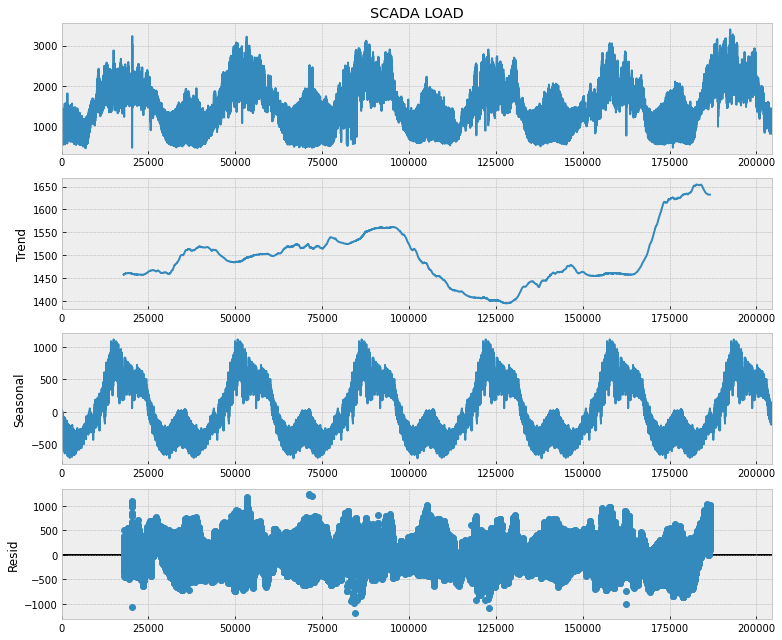

In [38]:
rcParams['figure.figsize'] = 11, 9

decomposed_demand_load = sm.tsa.seasonal_decompose(final_set['SCADA LOAD'],freq=35700) 

# THE FREQUENCY IS ANNUAL.
# 1 Days = 96 Slots
# 1 Month = 96 * 31 Days = 2976 slots approx.
# 1 Year = 2976 * 12 Months = 35712 slots approx. 

figure = decomposed_demand_load.plot()
plt.show()

## Load data distribution Between Demand and SCADA

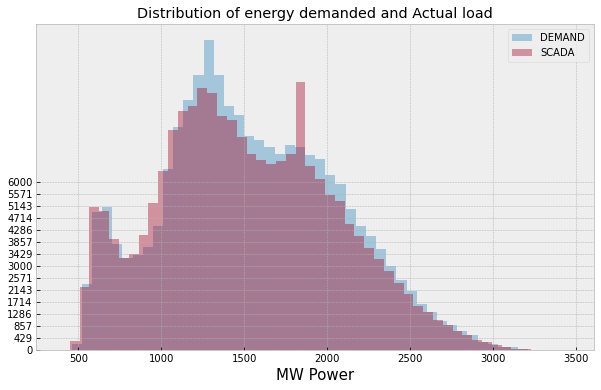

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(final_set['DEMAND LOAD'].dropna(), ax=ax, kde=False).set_title('DEMAND LOAD', fontsize=16)
sns.distplot(final_set['SCADA LOAD'].dropna(), ax=ax, kde=False).set_title('SCADA LOAD', fontsize=16)
plt.xlabel('MW Power', fontsize=15)
plt.legend(['DEMAND', 'SCADA'])
ax.set_yticks(np.linspace(0, 6000, 15))
plt.title('Distribution of energy demanded and Actual load')
plt.show()

## Load Data Distribution of Month of years (2017-2022)

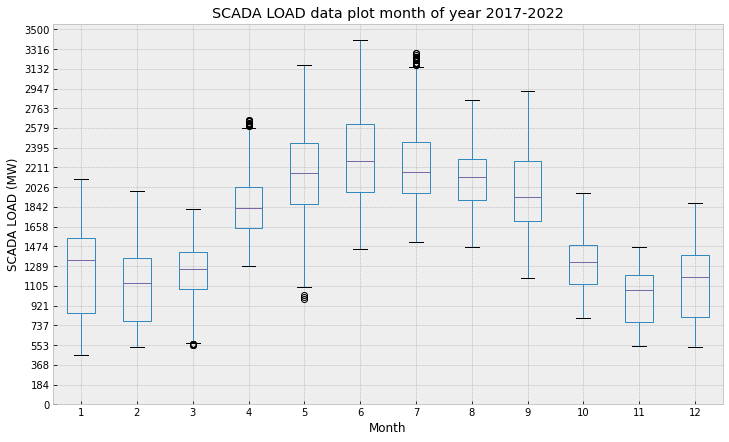

In [40]:
fig, axs = plt.subplots(1, 1,  figsize=(12,7))

final_set.set_index('DATETIME', inplace=True)

groups = final_set['SCADA LOAD'].groupby(pd.Grouper(freq='M'))

df = pd.DataFrame()

for name, group in groups:
    df[name.month] = pd.Series(group.values)

df.boxplot(ax=axs)
axs.set_xlabel('Month')
axs.set_ylabel('SCADA LOAD (MW)')
axs.set_title('SCADA LOAD data plot month of year 2017-2022')
axs.set_yticks(np.linspace(0,3500,20))
plt.subplots_adjust(hspace=0.5)

plt.show()

## Monthly Mean SCADA Load Data (2017-2022)

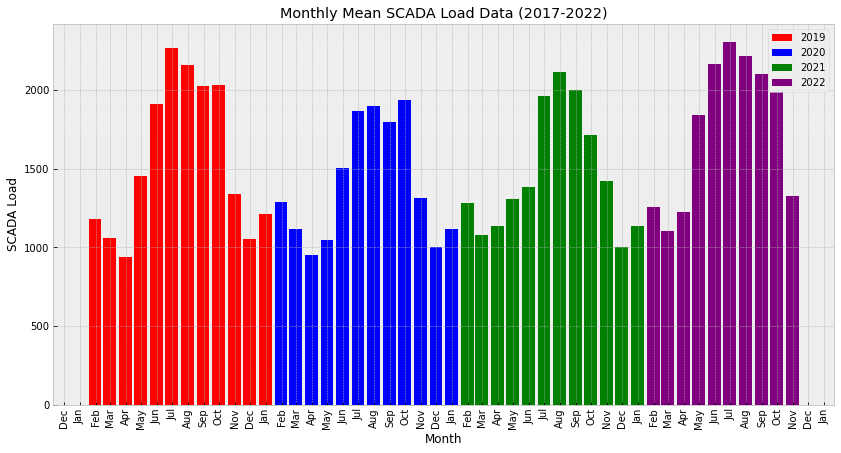

In [41]:
df_month = final_set.resample("M").mean()

fig, ax = plt.subplots(figsize=(14, 7))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

colors = ['red', 'blue', 'green', 'purple', 'orange', 'gray']

# loop through the years and plot the bars with the corresponding color
for i, year in enumerate(range(2019, 2022+1)):
    ax.bar(df_month[str(year)].index, 
           df_month.loc[str(year), "SCADA LOAD"], 
           width=25, align='center', 
           color=colors[i], label=str(year))

# set the X-axis tick locator to show one tick per month
ax.xaxis.set_major_locator(mdates.MonthLocator())

# set the X-axis tick formatter to show the abbreviated month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_xlabel('Month')
plt.xticks(rotation = 90)
ax.set_ylabel('SCADA Load')
ax.set_title('Monthly Mean SCADA Load Data (2017-2022)')
ax.legend()
plt.show()

## Minimum and Maximum SCADA Load profile (2017-2022)

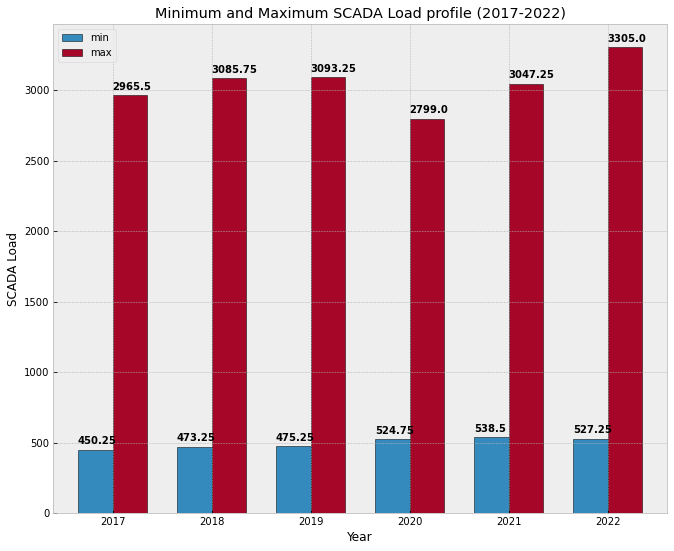

In [42]:
df_hourly = final_set.resample("H").mean()
df_hourly.reset_index(inplace=True)

df_hourly['DATETIME'] = df_hourly['DATETIME'].dt.year
min_max_load = df_hourly.groupby('DATETIME')['SCADA LOAD'].agg(['min', 'max'])

ax = min_max_load.plot.bar(rot=0,  width=0.7, edgecolor='black')

for i, val in enumerate(min_max_load['min']):
    ax.text(i-0.35, val+40, str(val), color='black', fontweight='bold')
for i, val in enumerate(min_max_load['max']):
    ax.text(i+0.00, val+40, str(val), color='black', fontweight='bold')

    
ax.set_xlabel('Year')
ax.set_title('Minimum and Maximum SCADA Load profile (2017-2022)')
ax.set_ylabel('SCADA Load')
plt.show()

## Weekly Mean Load Data of DEMAND, SCADA and SLDC (2017-2022)

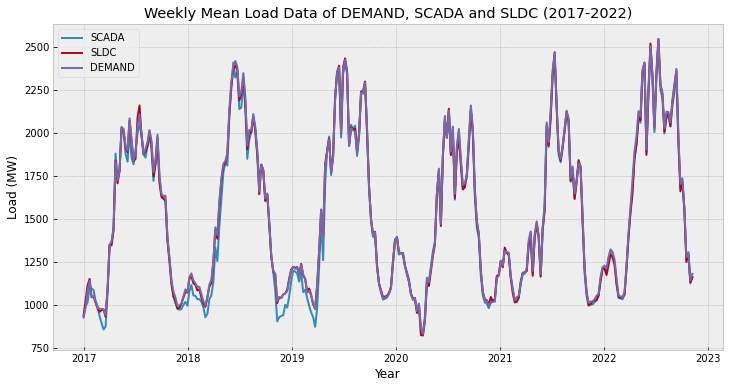

In [43]:
SCADA_weekly = final_set['SCADA LOAD'].resample('W').mean()
SLDC_weekly = final_set['SLDC LOAD'].resample('W').mean()
Demand_weekly = final_set['DEMAND LOAD'].resample('W').mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=SCADA_weekly, label='SCADA')
sns.lineplot(data=SLDC_weekly, label='SLDC')
sns.lineplot(data=Demand_weekly, label='DEMAND')
plt.xlabel('Year')
plt.ylabel('Load (MW)')
plt.title('Weekly Mean Load Data of DEMAND, SCADA and SLDC (2017-2022)')
plt.legend()
plt.show()

## Seasonal Decompose for Weather Data

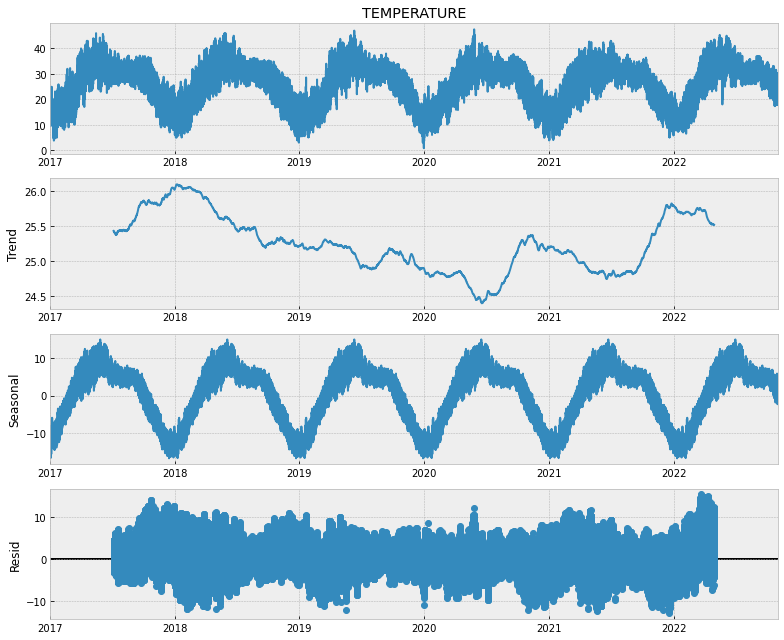

In [44]:
rcParams['figure.figsize'] = 11, 9

decomposed_demand_load = sm.tsa.seasonal_decompose(final_set['TEMPERATURE'],freq=35700) 

# THE FREQUENCY IS ANNUAL.
# 1 Days = 96 Slots
# 1 Month = 96 * 31 Days = 2976 slots approx.
# 1 Year = 2976 * 12 Months = 35712 slots approx. 

figure = decomposed_demand_load.plot()
plt.show()

## Weather Data Distribution of Month of years (2017-2022)

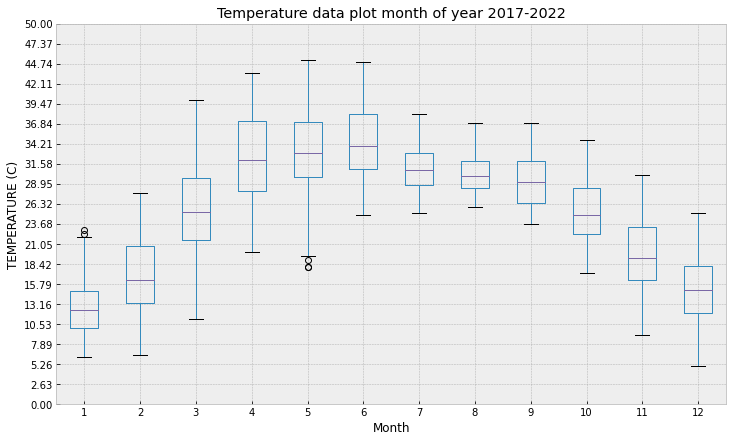

In [45]:
fig, axs = plt.subplots(1, 1,  figsize=(12,7))

groups = final_set['TEMPERATURE'].groupby(pd.Grouper(freq='M'))

df = pd.DataFrame()

for name, group in groups:
    df[name.month] = pd.Series(group.values)

df.boxplot(ax=axs)
axs.set_xlabel('Month')
axs.set_ylabel('TEMPERATURE (C)')
axs.set_title('Temperature data plot month of year 2017-2022')
axs.set_yticks(np.linspace(0,50,20))
plt.subplots_adjust(hspace=0.5)

plt.show()

## Weekly Mean Temperature and Humidity Data (2017-2022)

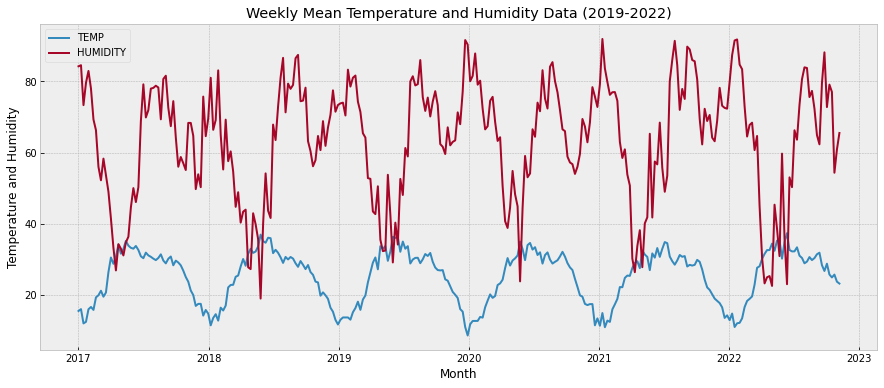

In [46]:
Temp_weekly = final_set['TEMPERATURE'].resample('W').mean()
Humd_weekly = final_set['HUMIDITY'].resample('W').mean()

plt.figure(figsize=(15, 6))
sns.lineplot(data=Temp_weekly, label='TEMP')
sns.lineplot(data=Humd_weekly, label='HUMIDITY')
plt.xlabel('Month')
plt.ylabel('Temperature and Humidity')
plt.title('Weekly Mean Temperature and Humidity Data (2019-2022)')
plt.legend()
plt.show()

## Minimum and Maximum Temperature profile (2019-2022)

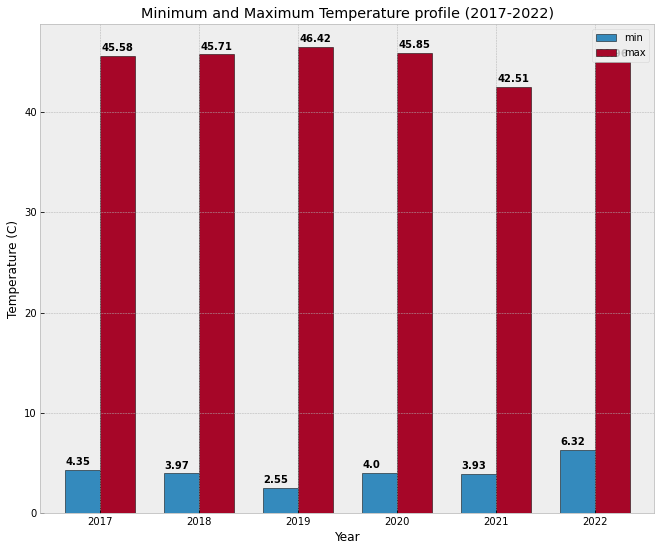

In [47]:
df_hourly = final_set.resample("H").mean()
df_hourly.reset_index(inplace=True)

df_hourly['DATETIME'] = df_hourly['DATETIME'].dt.year
min_max_load = df_hourly.groupby('DATETIME')['TEMPERATURE'].agg(['min', 'max'])

ax = min_max_load.plot.bar(rot=0,  width=0.7, edgecolor='black')

for i, val in enumerate(min_max_load['min']):
    ax.text(i-0.35, val+0.5, str(round(val ,2)), color='black', fontweight='bold')
for i, val in enumerate(min_max_load['max']):
    ax.text(i+0.02, val+0.5, str(round(val ,2)), color='black', fontweight='bold')
    
ax.set_xlabel('Year')
ax.set_title('Minimum and Maximum Temperature profile (2017-2022)')
ax.set_ylabel('Temperature (C)')
plt.show()

## Monthly SCADA Load and Weather Data (2017-2022)

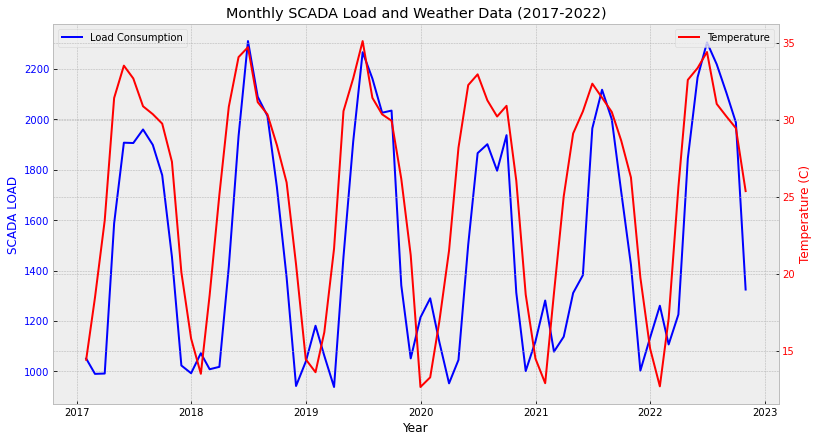

In [48]:
load_monthly = final_set.resample('M').mean()
Temp_monthly = final_set.resample('M').mean()

fig, ax1 = plt.subplots(figsize=(13, 7))

ax1.plot(load_monthly["SCADA LOAD"], color="blue")
ax1.set_xlabel("Year")
ax1.set_ylabel("SCADA LOAD", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 =ax1.twinx()

ax2.plot(Temp_monthly["TEMPERATURE"], color="red")
ax2.set_ylabel("Temperature (C)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

ax1.legend(["Load Consumption"], loc="upper left")
ax2.legend(["Temperature"], loc="upper right")

plt.title("Monthly SCADA Load and Weather Data (2017-2022)")
plt.show()

# Spliting of dataset into Train, Validation and Test Set

In [49]:
final_set.reset_index(inplace=True)
min_date = final_set.DATETIME.dt.date.min()
max_date = final_set.DATETIME.dt.date.max()

print('Start Date:', min_date)
print('End Date:', max_date)

Start Date: 2017-01-01
End Date: 2022-10-31


In [51]:
final_set.set_index('DATETIME', inplace=True)

Split data into 70% of Training set, 10% of Validation Set and 20% of Test set

## Train set

In [53]:
train_percent = 0.7

time_between = max_date - min_date

train_start_date = min_date + pd.DateOffset(hours=0, minutes=0)
print('Start Date : ', train_start_date)

train_cutoff_date = min_date + train_percent * time_between
train_end_date = train_cutoff_date + pd.DateOffset(hours=23, minutes=45)
print('End Date   : ', train_end_date)

tsp_train_set = final_set.loc[train_start_date:train_end_date]
tsp_train_set.reset_index(inplace=True)

Start Date :  2017-01-01 00:00:00
End Date   :  2021-01-30 23:45:00


## Validation Set

In [55]:
val_percent = 0.1

val_start_date = train_cutoff_date + pd.DateOffset(days=1)
print('Start Date : ', val_start_date)

val_cutoff_date = val_start_date.date() + val_percent * time_between
val_end_date = val_cutoff_date + pd.DateOffset(hours=23, minutes=45)
print('End Date   : ', val_end_date)

tsp_val_set = final_set.loc[val_start_date:val_end_date]
tsp_val_set.reset_index(inplace=True)

Start Date :  2021-01-31 00:00:00
End Date   :  2021-08-31 23:45:00


## Test Set

In [57]:
test_percent = 0.2

test_start_date = val_cutoff_date + pd.DateOffset(days=1)
print('Start Date : ', test_start_date)

test_end_date = max_date + pd.DateOffset(hours=23, minutes=45)
print('End Date   : ', test_end_date)

tsp_test_set = final_set.loc[test_start_date:test_end_date]
tsp_test_set.reset_index(inplace=True)

Start Date :  2021-09-01 00:00:00
End Date   :  2022-10-31 23:45:00


# Data Normalization

In [58]:
scaler = MinMaxScaler(feature_range = (0, 1))

In [59]:
tsp_scaled_train_set = tsp_train_set.drop(labels=['DATETIME'],axis=1).copy()
tsp_scaled_val_set = tsp_val_set.drop(labels=['DATETIME'],axis=1).copy()
tsp_scaled_test_set = tsp_test_set.drop(labels=['DATETIME'],axis=1).copy()

In [60]:
tsp_scaled_train_set = scaler.fit_transform(tsp_scaled_train_set)
tsp_scaled_val_set = scaler.fit_transform(tsp_scaled_val_set)
tsp_scaled_test_set = scaler.fit_transform(tsp_scaled_test_set)

## Reshape data for input of CNN-LSTM Model 

In [61]:
def create_sequences(ds, lb, look_back):
    windowed_dataset = []
    labels = []
    for i in range(look_back, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - look_back:i])
        labels.append(lb[i - 1])
        
    return np.array(windowed_dataset), np.array(labels)

### The input data can then be reshaped to have the required structure: [samples, features, timesteps]

In [62]:
look_back = 96
X_train, y_train = create_sequences(tsp_scaled_train_set[:,0:-1], tsp_scaled_train_set[:, -1], look_back)
X_val, y_val = create_sequences(tsp_scaled_val_set[:,0:-1], tsp_scaled_val_set[:, -1], look_back)
X_test, y_test = create_sequences(tsp_scaled_test_set[:,0:-1], tsp_scaled_test_set[:, -1], look_back)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(143041, 96, 12) (143041,) (20353, 96, 12) (20353,) (40801, 96, 12) (40801,)


# CNN-LSTM Model Implementation

In [70]:
tf.keras.backend.clear_session()

# CNN Implementations
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=2, 
                           strides=1, 
                           activation="relu", 
                           input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1),
    
# LSTM Implementations
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_regularizer=L1(0.03))])

model1.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer='adam',
              metrics=['mae'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 95, 32)            800       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 94, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 16)            1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 91, 16)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 flatten (Flatten)           (None, 32)                0

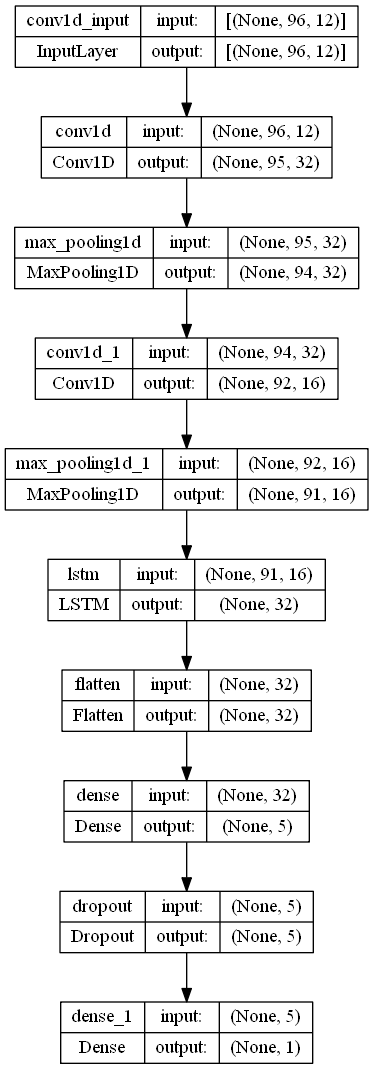

In [71]:
plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)

## Train Model

In [72]:
tf.config.run_functions_eagerly(True)
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=100)

Epoch 1/40
1431/1431 [==============================] - 493s 339ms/step - loss: 0.0316 - mae: 0.0725 - val_loss: 0.0060 - val_mae: 0.0446
Epoch 2/40
1431/1431 [==============================] - 556s 389ms/step - loss: 0.0075 - mae: 0.0500 - val_loss: 0.0044 - val_mae: 0.0403
Epoch 3/40
1431/1431 [==============================] - 551s 385ms/step - loss: 0.0063 - mae: 0.0476 - val_loss: 0.0026 - val_mae: 0.0269
Epoch 4/40
1431/1431 [==============================] - 585s 409ms/step - loss: 0.0061 - mae: 0.0472 - val_loss: 0.0037 - val_mae: 0.0400
Epoch 5/40
1311/1431 [==========================>...] - ETA: 42s - loss: 0.0059 - mae: 0.0466

KeyboardInterrupt: 

## Save the model

In [ ]:
pre_5y_saved_model = pickle.dumps(model1)
model_for_5year_data_pickle = pickle.loads(pre_5y_saved_model)

# Evaluate and Predict

In [78]:
loss, mae = model1.evaluate(X_test, y_test)

1276/1276 [==============================] - 160s 126ms/step - loss: 0.0023 - mae: 0.0306


In [79]:
y_pred = model1.predict(X_test)

1276/1276 [==============================] - 154s 121ms/step


### Training Loss v/s Validation Loss

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training loss vs Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Training MAE v/s Validation MAE

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model train vs Validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Inverse Transform on test dataset to get the actual value

In [91]:
y_test_array = np.repeat(y_test, 13, axis=-1)
y_test_array_new = y_test_array.reshape(-1, 13)
y_test_actual = scaler.inverse_transform(y_test_array_new)[:, -1]
y_test_actual

530413

In [90]:
y_test_pred_array = np.repeat(y_pred, 13, axis=-1)
y_test_predict = scaler.inverse_transform(y_test_pred_array)[:, -1]
y_test_predict

array([1563.03  , 1544.5632, 1548.4572, ...,  927.0775,  909.7471,
        893.7071], dtype=float32)

### Creating a dataframe to compare the actual SCADA LOAD with predicted SCADA LOAD and also check for OD/UD of predicted value

In [94]:
actual_load_df = pd.DataFrame(y_test_actual, columns=['ACTUAL SCADA LOAD'])
pred_load_df = pd.DataFrame(y_test_predict, columns=['PRED. SCADA LOAD'])

In [95]:
new_date = test_start_date + pd.DateOffset(hours=23, minutes=45)
date_index = pd.date_range(start=new_date, end=test_end_date, freq='15T')
datetime_df = pd.DataFrame({'DATETIME': date_index + pd.DateOffset(hours=0, minutes=0)})

In [96]:
comp_df = pd.concat([datetime_df, actual_load_df, pred_load_df], axis=1)

comp_df['difference'] = comp_df['PRED. SCADA LOAD'].astype(int) - comp_df['ACTUAL SCADA LOAD'].astype(int)

comp_df['OD/UD PRED. SCADA LOAD'] = comp_df['difference'].apply(lambda x: '{0}{1}'.format('-' if x < 0 else '+', abs(x)))

comp_df = pd.concat([datetime_df, actual_load_df.astype(int), pred_load_df.astype(int), comp_df['OD/UD PRED. SCADA LOAD']], axis=1)
comp_df

,DATETIME,ACTUAL SCADA LOAD,PRED. SCADA LOAD,OD/UD PRED. SCADA LOAD
0,2021-09-01 23:45:00,1582,1563,-19
1,2021-09-02 00:00:00,1558,1544,-14
2,2021-09-02 00:15:00,1531,1548,+17
3,2021-09-02 00:30:00,1508,1568,+60
4,2021-09-02 00:45:00,1491,1528,+37
...,...,...,...,...
40796,2022-10-31 22:45:00,1032,971,-61
40797,2022-10-31 23:00:00,1007,948,-59
40798,2022-10-31 23:15:00,982,927,-55
40799,2022-10-31 23:30:00,957,909,-48


In [97]:
comp_df.set_index('DATETIME', inplace=True)

## Hourly data comparsion of Predicted SCADA Load with Actual SCADA Load

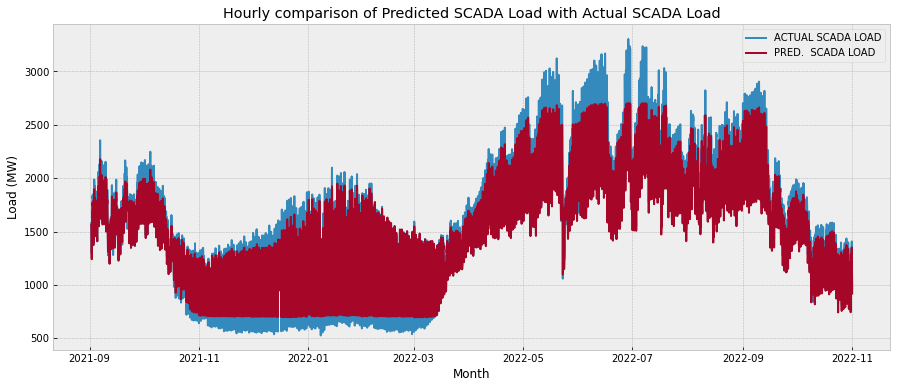

In [100]:
comp_hourly = comp_df.resample("H").mean()

plt.figure(figsize=(15, 6))
sns.lineplot(data=comp_hourly['ACTUAL SCADA LOAD'], label='ACTUAL SCADA LOAD')
sns.lineplot(data=comp_hourly['PRED. SCADA LOAD'], label='PRED.  SCADA LOAD')
plt.xlabel('Month')
plt.ylabel('Load (MW)')
plt.title('Hourly comparison of Predicted SCADA Load with Actual SCADA Load')
plt.legend()
plt.show()

## Daywise comparsion of  Predicted SCADA Load with Actual SCADA Load on test data

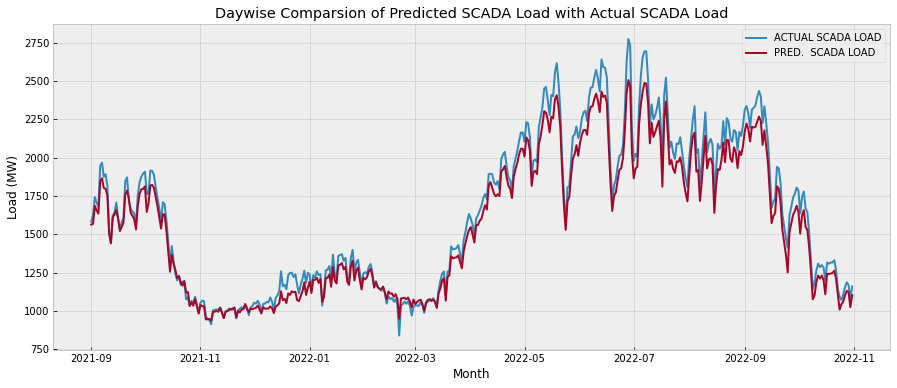

In [101]:
comp_hourly = comp_df.resample("D").mean()

plt.figure(figsize=(15, 6))
sns.lineplot(data=comp_hourly['ACTUAL SCADA LOAD'], label='ACTUAL SCADA LOAD')
sns.lineplot(data=comp_hourly['PRED. SCADA LOAD'], label='PRED.  SCADA LOAD')
plt.xlabel('Month')
plt.ylabel('Load (MW)')
plt.title('Daywise Comparsion of Predicted SCADA Load with Actual SCADA Load')
plt.legend()
plt.show()

## Weekly data comparsion of Predicted SCADA Load with Actual SCADA Load

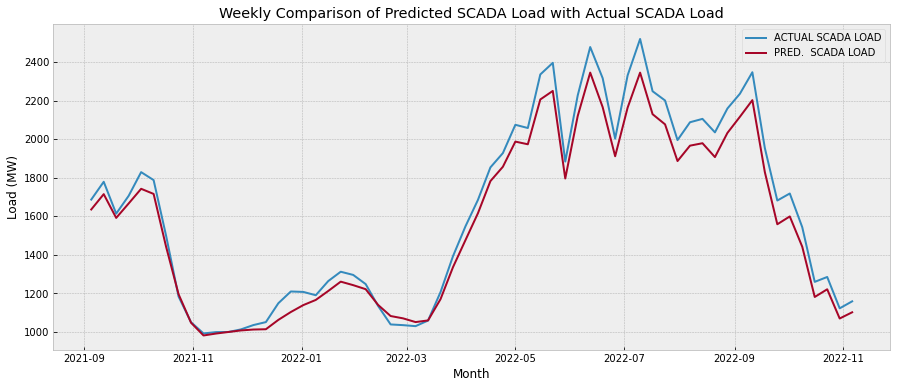

In [102]:
comp_weekly = comp_df.resample("W").mean()

plt.figure(figsize=(15, 6))
sns.lineplot(data=comp_weekly['ACTUAL SCADA LOAD'], label='ACTUAL SCADA LOAD')
sns.lineplot(data=comp_weekly['PRED. SCADA LOAD'], label='PRED.  SCADA LOAD')
plt.xlabel('Month')
plt.ylabel('Load (MW)')
plt.title('Weekly Comparison of Predicted SCADA Load with Actual SCADA Load')
plt.show()

## Over and Under Predicted SCADA Load as per actual SCADA Load

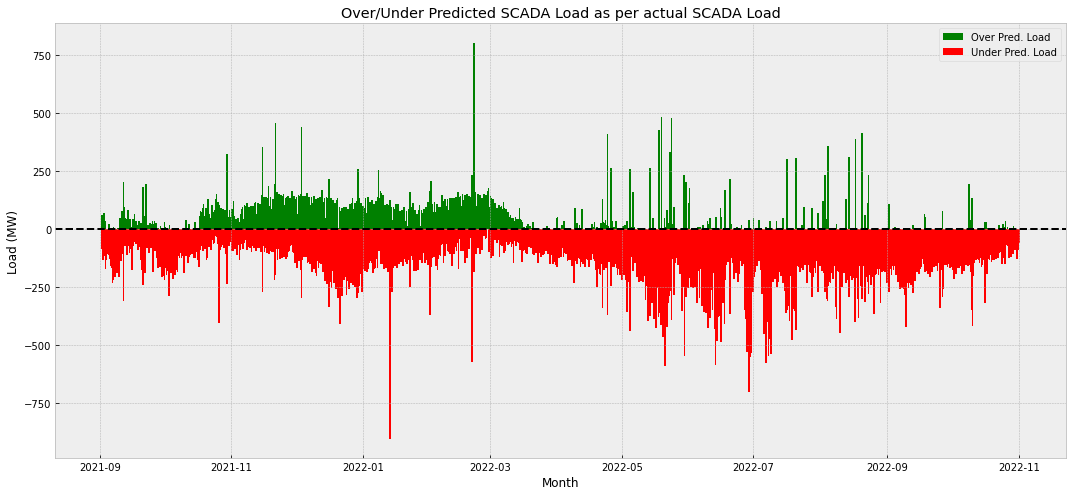

In [103]:
fig, ax = plt.subplots(figsize=(15, 7))

od_df = comp_df[comp_df['OD/UD PRED. SCADA LOAD'].astype(int) >= 0]
ud_df = comp_df[comp_df['OD/UD PRED. SCADA LOAD'].astype(int) < 0]

green_colors = ['g' for _ in od_df.index]
red_colors = ['r' for _ in ud_df.index]

ax.bar(od_df.index, od_df['OD/UD PRED. SCADA LOAD'].astype(int), color=green_colors, label='Over Pred. Load')
ax.bar(ud_df.index, ud_df['OD/UD PRED. SCADA LOAD'].astype(int), color=red_colors, label='Under Pred. Load')

ax.set_title('Over/Under Predicted SCADA Load as per actual SCADA Load')
ax.set_xlabel('Month')
ax.set_ylabel('Load (MW)')
ax.axhline(y=0, color='black', linestyle='--')
ax.legend(loc='upper right')

fig.tight_layout()
plt.show()

# Evaluation Metrics

In [104]:
def mean_absolute_percentage_error(test, pred, epsilon=1e-8):
    return np.mean(np.abs((test - pred) / (test + epsilon))) * 100

def forecasting_absolute_deviation_index(dataset):
    length_of_dataset = len(dataset)
    sum_of_value = sum(dataset)
    mean = sum_of_value / length_of_dataset
    deviations = [abs(num - mean) for num in dataset]
    return sum(deviations) / len(deviations)

#### 1. Mean Squared Error

In [105]:
mse = MeanSquaredError()
mse.update_state(y_test, y_pred)
mse_result = mse.result().numpy()

#### 2. Mean Absolute Error

In [106]:
mae = MeanAbsoluteError()
mae.update_state(y_test, y_pred)
mae_result = mae.result().numpy()

#### 3. Root Mean Squared Error

In [107]:
rmse = RootMeanSquaredError()
rmse.update_state(y_test, y_pred)
rmse_result = rmse.result().numpy()

#### 4. R2 Score

In [108]:
r2_result = r2_score(y_test, y_pred) * 100

#### 5. Mean Absolute Precentage Error

In [109]:
mape_result = mean_absolute_percentage_error(y_test_actual, y_test_predict)

#### 6. Forecasting Absolute Deviation Index (FADI)

In [110]:
comp_df = comp_df.astype(int)
dataset = list(comp_df['OD/UD PRED. SCADA LOAD'])

In [111]:
fadi_result = forecasting_absolute_deviation_index(dataset)

# Summary

In [112]:
col_name = ['', 'MSE', 'MAE', 'RMSE', 'R2', 'MAPE', 'FADI']
metrics = ['', mse_result, mae_result, rmse_result, r2_result, mape_result, fadi_result]

metrics_table = pd.DataFrame([metrics], columns=col_name)
metrics_table = metrics_table.set_index([''])
metrics_table.style.set_caption('Model Performance on 5 Years BRPL Load Data')

,MSE,MAE,RMSE,R2,MAPE,FADI
,,,,,,
,0.001429,0.030596,0.037804,96.042619,5.738141,62.466738
